In [1]:
__author__ = 'David Nidever <dnidever@noao.edu>'
__version__ = '20190104' # yyymmdd; version stamp of this notebook
__datasets__ = ['splus_dr1'] # datasets used in this notebook
__keywords__ = ['science example'], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] 

# Spectral Energy Distributions with S-PLUS DR1

*David Nidever & NOAO Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Query the data](#query)
* [Color Magnitude Diagrams](#cmd)
* [Color-Color Diagrams](#twocd)
* [Spectral Energy Distributions](#sed)
* [Spatial Density Map](#spatial)
* [Image Cutouts](#cutouts)
* [Resources](#resource)


<a class="anchor" id="goals"></a>
# Goals

We will show some examples of what can be done with the S-PLUS DR1 dataset focusing on the large number of photometric bands and spectral energy distributions.


# Summary

We will create a color magnitude diagram, color-color diagram, spectral energy distribution and image cutouts.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

# Imports and setup

In [2]:
# std lib
from getpass import getpass
import warnings
warnings.filterwarnings('ignore') # to suppress some astropy depracation warnings

# 3rd party
import numpy as np
from astropy import utils, io, convolution, stats
from astropy.visualization import make_lupton_rgb
from photutils import find_peaks
from pyvo.dal import sia
import pylab as plt
%matplotlib inline
import pandas as pd
pd.options.display.max_rows = 999

# Data Lab
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert

# plots default setup
plt.rcParams['font.size'] = 14

 <a class="anchor" id="query"></a>
# Query the S-PLUS DR1 database

Let's see how we query the S-PLUS DR1 database.  With no specific spatial region in mind we'll just take the first 10,000 objects.

## Construct the query string

In [3]:
# Create the query string; SQL keyword capitalized for clarity
query =\
"""SELECT *
   FROM splus_dr1.stripe82
   LIMIT 10000"""

# Submit the query
Running the query in synchroneous mode is very easy.

In [4]:
%%time
response = qc.query(query) # response is by default a CSV-formatted string

CPU times: user 285 ms, sys: 115 ms, total: 400 ms
Wall time: 7.1 s


We can use a helper function to convert the query result into a data structure. Let's convert to a Pandas dataframe:

In [5]:
R = convert(response,'pandas') # R is a pandas dataframe
print("Number of objects:", R.shape[0])
print(R.head())

Number of objects: 10000
                               id        ra     dec         x         y  \
0  SPLUS.STRIPE82-0107.00272.griz  315.0033 -1.3661  3159.804  1140.355   
1  SPLUS.STRIPE82-0107.00523.griz  315.0088 -1.3607  3124.337  1175.681   
2  SPLUS.STRIPE82-0107.00682.griz  315.0110 -1.3573  3109.874  1198.094   
3  SPLUS.STRIPE82-0107.00934.griz  315.0050 -1.3503  3148.772  1243.552   
4  SPLUS.STRIPE82-0107.00940.griz  315.0201 -1.3532  3050.348  1224.527   

   isoarea  aperture  s2ndet  photoflag   fwhm    ...      prob_gal  \
0     14.0       NaN   12.30          0   3.51    ...          1.00   
1     28.0       NaN   61.67          0   2.41    ...          0.00   
2     28.0       NaN   49.96          0   2.48    ...          0.00   
3     51.0       NaN   20.67          0  10.84    ...          0.99   
4    157.0       NaN  371.38          0   2.41    ...          0.00   

   prob_star     htm9  ring256   nest4096       glon       glat        elon  \
0       0.00  3096

Let's print out the column names

In [6]:
print(np.array(R.columns))

['id' 'ra' 'dec' 'x' 'y' 'isoarea' 'aperture' 's2ndet' 'photoflag' 'fwhm'
 'mumax' 'a' 'b' 'theta' 'flraddet' 'krraddet' 'ujava_auto' 'eujava_auto'
 's2n_ujava_auto' 'ujava_petro' 'eujava_petro' 's2n_ujava_petro'
 'ujava_aper' 'eujava_aper' 's2n_ujava_aper' 'f378_auto' 'ef378_auto'
 's2n_f378_auto' 'f378_petro' 'ef378_petro' 's2n_f378_petro' 'f378_aper'
 'ef378_aper' 's2n_f378_aper' 'f395_auto' 'ef395_auto' 's2n_f395_auto'
 'f395_petro' 'ef395_petro' 's2n_f395_petro' 'f395_aper' 'ef395_aper'
 's2n_f395_aper' 'f410_auto' 'ef410_auto' 's2n_f410_auto' 'f410_petro'
 'ef410_petro' 's2n_f410_petro' 'f410_aper' 'ef410_aper' 's2n_f410_aper'
 'f430_auto' 'ef430_auto' 's2n_f430_auto' 'f430_petro' 'ef430_petro'
 's2n_f430_petro' 'f430_aper' 'ef430_aper' 's2n_f430_aper' 'g_auto'
 'eg_auto' 's2n_g_auto' 'g_petro' 'eg_petro' 's2n_g_petro' 'g_aper'
 'eg_aper' 's2n_g_aper' 'f515_auto' 'ef515_auto' 's2n_f515_auto'
 'f515_petro' 'ef515_petro' 's2n_f515_petro' 'f515_aper' 'ef515_aper'
 's2n_f515_aper' 'r

<a class="anchor" id="cmd"></a>
# Make a Color Magnitude Diagram

Let us look at what a S-PLUS Color Magnitude Diagram (CMD) looks like.
First a scatter plot and then a density map.

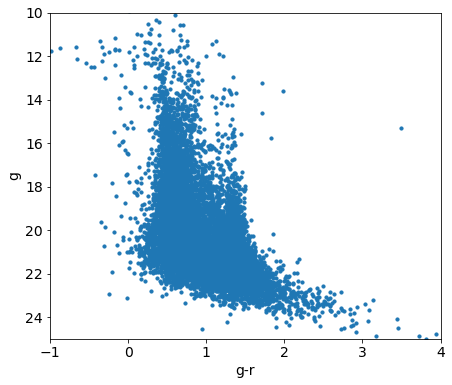

In [7]:
fig = plt.figure(figsize=(7,6))
plt.scatter(R['g_auto']-R['r_auto'], R['g_auto'], s=10)
plt.xlim(-1,4)
plt.ylim(25,10)
plt.xlabel('g-r')
plt.ylabel('g')

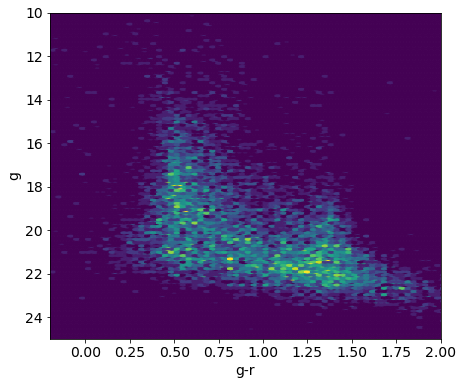

In [8]:
fig = plt.figure(figsize=(7,6))
plt.hexbin(R['g_auto']-R['r_auto'], R['g_auto'], extent=(-1,4,25,10),gridsize=(150,100))
plt.xlim(-0.2,2)
plt.ylim(25,10)
plt.xlabel('g-r')
plt.ylabel('g')

<a class="anchor" id="twocd"></a>
# Make a color-color diagram

The many S-PLUS photometric bands can be used to produce color-color diagrams that are useful for measuring properties such as the metallicity or surface gravity of a star.

(g-F515) vs. (g-r) is sensitive to surface gravity and can be used to separate dwarf stars from giant stars.  The main locus of points is the dwarfs will the red giant live in the upper right.  [See Majewski et al. (2000)](http://adsabs.harvard.edu/abs/2000AJ....120.2550M) for more details on this method.

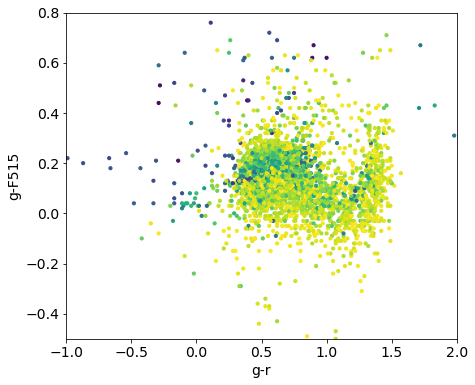

In [9]:
fig = plt.figure(figsize=(7,6))
bright = (R['g_auto']<20)
plt.scatter(R['g_auto'][bright]-R['r_auto'][bright], R['g_auto'][bright]-R['f515_auto'][bright],c=R['g_auto'][bright],s=10)
plt.xlim(-1,2)
plt.ylim(-0.5,0.8)
plt.xlabel('g-r')
plt.ylabel('g-F515')

The (F378-F410) vs. (F515-F861) is a similar color-color plot that can be used to derive surface gravity. See [Cenarro et al. (2018)](http://adsabs.harvard.edu/abs/2018arXiv180402667C) for more details.

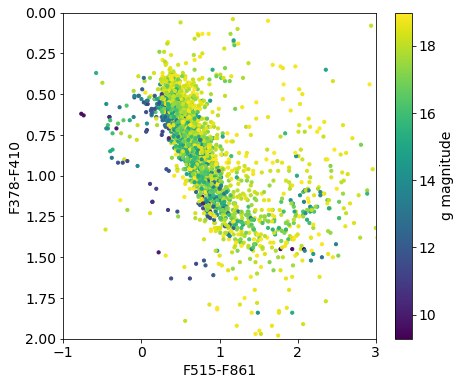

In [10]:
fig = plt.figure(figsize=(7,6))
bright = (R['g_auto']<19)
plt.scatter(R['f515_auto'][bright]-R['f861_auto'][bright], R['f378_auto'][bright]-R['f410_auto'][bright],c=R['g_auto'][bright],s=10)
plt.xlim(-1,3)
plt.ylim(2.0,0.0)
plt.xlabel('F515-F861')
plt.ylabel('F378-F410')
cbar = plt.colorbar()
cbar.set_label('g magnitude')

<a class="anchor" id="sed"></a>
# Creating Spectral Energy Distributions
One of the great advantages of the S-PLUS dataset is the large number of wide and narrow-band filters that can be used
to study the properties of the objects.  Here we show how plot the Spectral Energy Distributions (SEDs) of objects.  These can then be compared to spectral models to constrain properties such as Teff, logg and metallicity (for stars) and galaxy type and redshift for galaxies (see [Cennaro et al. 2018](http://adsabs.harvard.edu/abs/2018arXiv180402667C) for some examples).

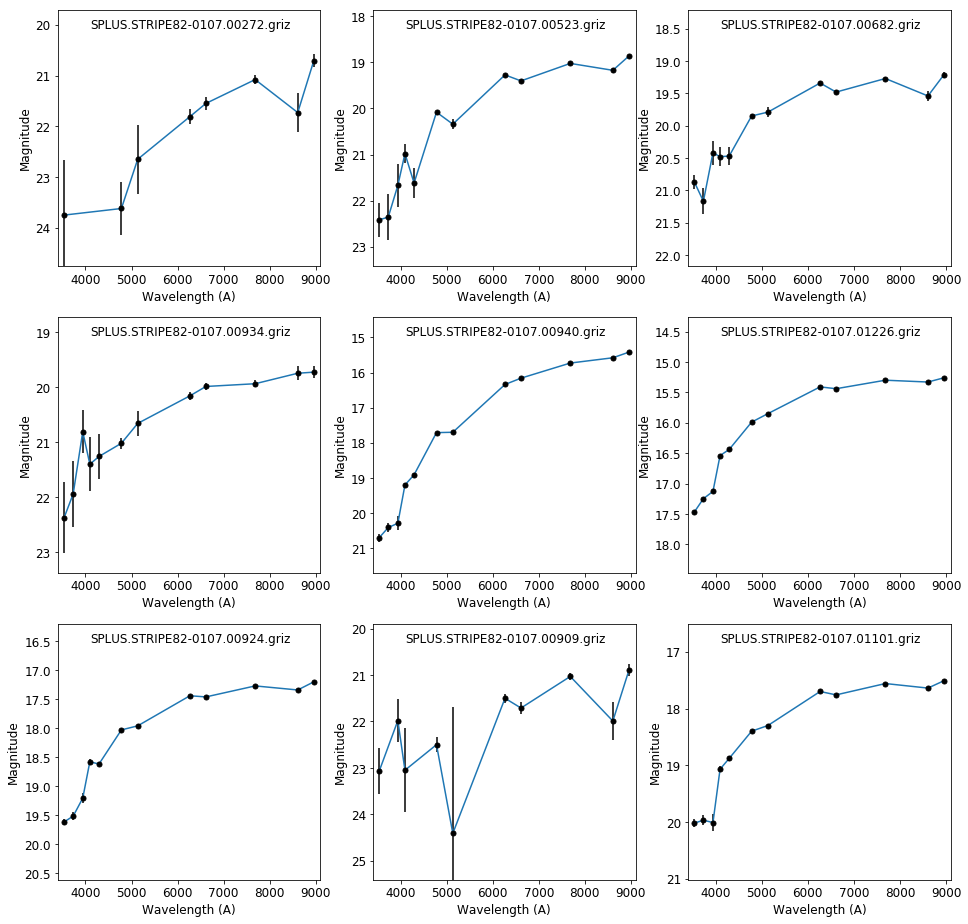

In [11]:
fig = plt.figure(figsize=(16,16))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font',**font)
bands = ['ujava','f378','f395','f410','f430','g','f515','r','f660','i','f861','z']
wave = np.array([3536.,3733.,3941.,4095.,4293.,4780.,5134.,6267.,6614.,7684.,8608.,8956.])
for j in range(9):
    ax = fig.add_subplot(3,3,j+1)
    mag = []
    err = []
    for b in bands:
        mag.append(R[b+'_auto'][j])
        err.append(R['s2n_'+b+'_auto'][j])
    mag = np.array(mag)
    err = 1.087/np.array(err)
    gd = (mag < 50)
    ax.plot(wave[gd],mag[gd])
    #ax.scatter(wave[gd],mag[gd])
    #ax.errorbar(wave[gd],mag[gd],yerr=err[gd], fmt='o', color='black',
    #         ecolor='lightgray', elinewidth=3, capsize=0);
    ax.errorbar(wave[gd],mag[gd],yerr=err[gd], fmt='.k',markersize=10)
    ax.set_xlim(3400,9100)
    ax.set_ylim(np.max(mag[gd])+1.0,np.min(mag[gd])-1.0)
    ax.set_xlabel('Wavelength (A)')
    ax.set_ylabel('Magnitude')
    ax.text(4100.0,np.min(mag[gd])-1.0+0.07*(np.max(mag[gd])-np.min(mag[gd])+2.0),R['id'][j]) 

<a class="anchor" id="spatial"></a>
# Make a figure of the spatial distribution

Let's make a spatial density map of the sources.

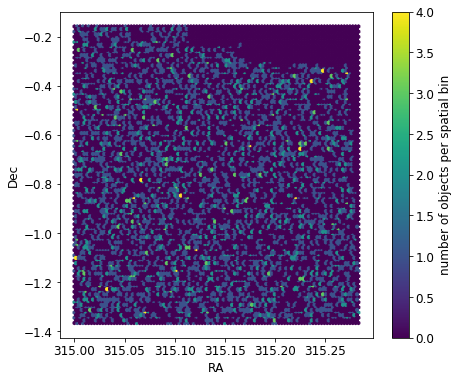

In [12]:
fig = plt.figure(figsize=(7,6))
plt.hexbin(R['ra'][0:5000], R['dec'][0:5000],gridsize=100)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='number of objects per spatial bin');

<a class="anchor" id="cuouts"></a>
# Image Cutouts

Let's get some image cutouts and make a three-color image.

First we define a few helper functions.

In [13]:
# set up SIA
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/splus_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

# a little func to download the deepest stacked images
def download_deepest_images(ra,dec,fov=0.1,bands=list('GRI')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    print("The full image list contains {:d} entries.".format(len(imgTable)))
    sel0 = (imgTable['proctype'] == b'Stack') & (imgTable['prodtype']==b'image') # basic selection
    images = []
    for band in bands:
        print("Band {:s}: ".format(band)) #, end='')
        sel = sel0 & (imgTable['obs_bandpass'] == band.encode()) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print('downloading deepest stacked image...')
        img = io.fits.getdata(utils.data.download_file(url.decode(),cache=True,show_progress=False,timeout=120)) # .decode() b/c in Python 3 url is of "byte" type and getdata() expects "string" type
        images.append(img)
        
    print("Downloaded {:d} images.".format(len(images)))
    return images

# multi panel image plotter
def plot_images(images,geo=None,panelsize=7,titles=list('gri'),cmap=plt.cm.gray_r):
    if geo is None:
        geo = (2,2)
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=plt.mpl.colors.PowerNorm(0.1))
        ax.set_title('{:s}'.format(titles[j]))
        plt.axis('off')

Now we download the deepest stacked images in three bands and combine them to make a 3-band color image.

In [14]:
bands = ['F515','R','I']
idx = 1
ra = 315.15
dec = -0.8
images = download_deepest_images(ra,dec, fov=0.1, bands=bands) # FOV in deg

The full image list contains 25 entries.
Band F515: 
downloading deepest stacked image...
Band R: 
downloading deepest stacked image...
Band I: 
downloading deepest stacked image...
Downloaded 3 images.


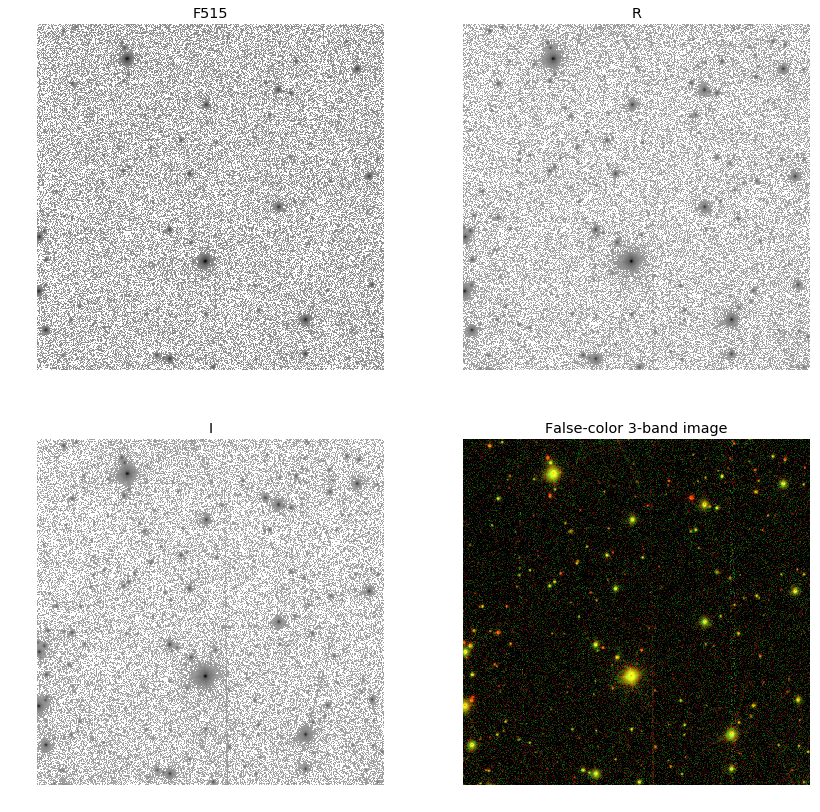

In [15]:
images2 = [im-np.median(im) for im in images] # subtract median from all images for better scaling
images2 += [make_lupton_rgb(*images2[::-1],stretch=0.5)] # add a 3-color composite image
plot_images(images2,titles=bands+['False-color 3-band image'])

# Some resources

Cenarro et al. (2018) "J-PLUS: The Javalambre Photometric Local Universe Survey":
http://adsabs.harvard.edu/abs/2018arXiv180402667C

Majewski et al. (2000) "Exploring Halo Substructure with Giant Stars. I. Survey Description and Calibration of the Photometric Search Technique": http://adsabs.harvard.edu/abs/2017AJ....154..199N
